## Necessary imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import re

In [2]:
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define helper functions

In [3]:
def listToString(array):
    return ("[" + ", ".join(f"'{str(i)}'" for i in array) + "]")

def stringToList(s):
    return list(map(int, s.strip('[]').split(',')))

In [4]:
def checkIfDominant(string):
    return string[1] == '7' or string[1] == '9' or string[1:3] == '13' or string[1:3] == '67'

def getDominantType(string):
        if string[1:3] == '13':
            return "13"
        if string[1:3] == '11':
            return "11"
        if string[1] == '9':
            return "9"
        if string[1] == '7':
            return "7"
        # if string[1:3] == '67':
        #     return '6'
        if string[1:3] == '67':
            return '67'


def getChordType(chord_noAcc, major, minor, diminished, dominant, dominant_type):

    if minor or diminished:
        if chord_noAcc[2] == "7":
            return "min7"
        elif chord_noAcc[2] == "9" or chord_noAcc[2] == "6": 
            return 'min' + chord_noAcc[2]
        elif chord_noAcc[2] == "1": 
            return 'min' + chord_noAcc[2:4]
        else:
            return "min5"

    if major:
        if chord_noAcc[4:6] == "67":
            return "maj67"
        if chord_noAcc[4] == "7":
            return "maj7"
        if chord_noAcc[4] == "9": 
            return 'maj9'
        # if chord_noAcc[4] == "6": ## Notation like C6 is used without maj.
            # return "maj6"
        elif chord_noAcc[4] == "1": 
            return 'maj' + chord_noAcc[4:6]

    if dominant:
        # print(dominant)
        return 'dominant' + dominant_type

    if not dominant and not major and not minor and not diminished:
        try:
            if chord_noAcc[1:4] == "aug":
                return "aug"
            if chord_noAcc[1:3] == "69":
                return "69"
            elif chord_noAcc[1] == "6":
                return "6"
            else:
                return "maj5"
                # return "uncertain"
        except IndexError:
            print('ERROR!')


def getAddDegree(chord):
    add_accidental = "N/A"
    add_idx = None
    addNote_degree = "N/A"

    add_idx = chord.find('add')

    if chord[add_idx+3] == '♭' or chord[add_idx+3] == '#':    ## Accidental found in add!
        add_accidental = chord[add_idx+3]

    if add_accidental == "N/A":
        if chord[add_idx+3] == "9":
            addNote_degree = "9"
        if chord[add_idx+3] == "6":
            addNote_degree = "6"
        if chord[add_idx+3] == "4":
            addNote_degree = "4"
        elif chord[add_idx+3] == "1":
            addNote_degree = chord[add_idx+3:chord[add_idx+4]]

    if add_accidental != "N/A":
        chord_addAccRemoved = chord[:add_idx+3] + chord[add_idx+4:]
        if chord_addAccRemoved[add_idx+3] == "9":
            addNote_degree =  "9"
        if chord_addAccRemoved[add_idx+3] == "6":
            addNote_degree = "6"
        elif chord_addAccRemoved[add_idx+3] == "1":
            addNote_degree = chord_addAccRemoved[add_idx+3:add_idx+5]

    return addNote_degree, add_accidental

In [5]:
def get_subdescriptor_dict(chord):
    root = chord[0]
    root_accidental = "♮"
    chord_noAcc = chord

    if chord[1] == "♭" or chord[1] == "#":
        root_accidental = chord[1]
        chord_noAcc = chord_noAcc[0:1] + chord_noAcc[2:]     ## Remove accidental for easier parsing

    dominant = checkIfDominant(chord_noAcc)
    dominant_type = "N/A" 
    
    if dominant:
        dominant_type = getDominantType(chord_noAcc)

    diminished = chord_noAcc[1] == 'o'
    minor = chord_noAcc[1] == 'm'

    major = 'Maj' in chord_noAcc[1:4] 
    sus4 = 'sus4' in chord_noAcc

    slash_note = 'N/A'
    alteration = []
    matches = []

    ## Check for '(♭5)' in  Fm9(♭5)
    if '/' in chord:
        index = chord.find('/')
        slash_note = chord[index+1:]

    if '(' in chord:
        start_index = chord.find('(')
        end_index = chord.find(')')

        alteration = chord[start_index+1:end_index]       
        pattern = "([♭#]\d+)"
        matches =  re.findall(pattern, alteration)        

    add_present = 'add' in chord or 'Δ' in chord
    add_accidental = "N/A"
    addNote_degree = "N/A"

    if add_present:
        add_idx = chord.find('add')
        addNote_degree, add_accidental = getAddDegree(chord)

    chord_type = ""
    chord_type = getChordType(chord_noAcc, major, minor, diminished, dominant, dominant_type)


    return {
            'root': root,
            'root_accidental': root_accidental,
            'chord_type': chord_type,
            'slash_note': slash_note,
            'alternations': matches,
            'diminished_substring': diminished,
            'major_substring': major,
            'minor_substring': minor,
            'dominant': dominant,
            'dominant_type': dominant_type,
            'sus4_substring': sus4,
            'addNote_accidental': add_accidental,
            'addNote_degree': addNote_degree,
        }
    

## Data Preparation

### Collect dataset images into a dictionary

In [6]:
# %%script echo skipping
import os
from PIL import Image

data_dir = "../output"

labels = []

dataset = {}
for filename in os.listdir(data_dir):
    if not filename.endswith(".png"):
        continue
    parts = filename.split("_")
    label = parts[-2]                   # Extract the second-to-last part as the label
    # print(label)
    labels.append(label)
    img_path = os.path.join(data_dir, filename)
    dataset[img_path] = label

In [7]:
# print(dataset)
print(len(dataset.items()))

502


### Define unique_subdescriptors_dict

In [8]:
unique_subdescriptors_dict = {
  "root": ["A", "B", "C", "D", "E", "F", "G"],
  "root_accidental": ["♮", "#", "♭"],
  "chord_type": [
    "maj5",
    "maj67",
    "maj7",
    "maj9",
    "maj#11",
    "maj13",
    "6",
    "69",
    "dominant6",
    "dominant67",
    "dominant7",
    "dominant9",
    "dominant13",
    "min5",
    "min6",
    "min7",
    "min9",
    "min11",
    "min13",
    "aug"
  ],
  "slash_note": ["A", "B", "C", "D", "E", "F", "G", "N/A"],
  "alternations": [
    "['♭5']",
    "['♭5', '#9']",
    "['#5']",
    "['#5', '#9']",
    "['#9']",
    "['#11']",
    "['♭6']",
    "['♭9', '#11']",
    "['♭9']",
    "['♭13']",
    "[]"
  ],
  "diminished_substring": ["False", "True"],
  "major_substring": ["False", "True"],
  "minor_substring": ["False", "True"],
  "dominant": ["False", "True"],
  "dominant_type": ["N/A", "67", "7", "9", "11", "13"],
  "sus4_substring": ["False", "True"],
  "addNote_accidental": ["N/A", "#", "♭"],
  "addNote_degree": ["N/A", "4", "6", "9", "11"]
}


In [9]:
import numpy as np
value_to_int = {}
int_to_value = {}

for label in unique_subdescriptors_dict:
    label_values = unique_subdescriptors_dict[label]
    for i, value in enumerate(label_values):
        value_to_int[(label, value)] = i
        int_to_value[(label, i)] = value

In [10]:
def create_binary_encoding(chord):

    chord_sublabels = get_subdescriptor_dict(chord)
    label_encoding = {}
    binary_encodings_concatenated = []

    for  key, val in chord_sublabels.items():

        if type(val) == list:
            val = listToString(val)
        if type(val) == bool:
            val = str(val)
        
        access_tuple = (key, val)
        label_encoding[key] = value_to_int[access_tuple]


    for chord_label, possibilities in unique_subdescriptors_dict.items(): # Shape => { root:['A', 'B', ..], root_accidental:[..] }
        # binary_encoding is the encoding for a each single array of possibilities
        binary_encoding = [0] * len(possibilities)
        binary_encoding[label_encoding[chord_label]] = 1
        binary_encodings_concatenated.extend(binary_encoding)

    
    return(binary_encodings_concatenated)

In [31]:
# print(create_binary_encoding("CMaj7"))
c_get_subdescriptor_dict = get_subdescriptor_dict("CMaj7")
print(c_get_subdescriptor_dict)


{'root': 'C', 'root_accidental': '♮', 'chord_type': 'maj7', 'slash_note': 'N/A', 'alternations': [], 'diminished_substring': False, 'major_substring': True, 'minor_substring': False, 'dominant': False, 'dominant_type': 'N/A', 'sus4_substring': False, 'addNote_accidental': 'N/A', 'addNote_degree': 'N/A'}


In [11]:
def binary_encoding_to_subdescriptor(binary_encoding, unique_subdescriptors_dict):
    # print('original binary_encoding', binary_encoding)
    subdescriptor_dict = {}
    for subdescriptor_name, subdescriptor_values in unique_subdescriptors_dict.items():
        
        subdescriptor_dict[subdescriptor_name] = subdescriptor_values[binary_encoding[0:len(subdescriptor_values)].argmax().item()]
        # print('slided by subdescriptor_name', subdescriptor_name)
        # print('slicied by length', len(subdescriptor_values))
        binary_encoding = binary_encoding[len(subdescriptor_values):]
        # print('sliced into', len(binary_encoding))
        # print(binary_encoding[0:len(subdescriptor_values)].argmax().item())
        # print('\n')
    return subdescriptor_dict

In [12]:
# print(create_binary_encoding("AMaj7"))
chord_t = create_binary_encoding("E7")
print('chord_t LENGTH:', len(chord_t))
print(binary_encoding_to_subdescriptor(torch.tensor(chord_t), unique_subdescriptors_dict))



chord_t LENGTH: 73
{'root': 'E', 'root_accidental': '♮', 'chord_type': 'dominant7', 'slash_note': 'N/A', 'alternations': '[]', 'diminished_substring': 'False', 'major_substring': 'False', 'minor_substring': 'False', 'dominant': 'True', 'dominant_type': '7', 'sus4_substring': 'False', 'addNote_accidental': 'N/A', 'addNote_degree': 'N/A'}


### Split Data

### Stack the image tensors into a single tensor

### Train / Test Split

In [13]:
true_labels_string_list = [*dataset.values()]
true_labels_string_list_tuple = [*dataset.items()]

### Define PreparedDataset Class

In [14]:
class PreparedDataset(Dataset):
    def __init__(self, data, binary_encoded_labels=None, transform=None):
        self.image_paths = data
        self.binary_labels = binary_encoded_labels
        self.transform = transform
        
    def __getitem__(self, idx):
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        if self.binary_labels is not None:
            single_binary_labels = self.binary_labels[idx]
            return image, single_binary_labels, self.image_paths[idx]

    def __len__(self):
        return len(self.image_paths)



### Create binary_encoded_labels


binary_encoded_labels is a list that will contain binary-encoded labels for all the examples in the dataset. Each binary-encoded label is a list of 1s and 0s representing the presence or absence of each unique sub-descriptor in the label.

In [15]:
binary_encoded_labels = []
for label in dataset.values():
    subdescriptor_dict = get_subdescriptor_dict(label)
    binary_encoding_sublabel = []
    for subdescriptor, possibilities in unique_subdescriptors_dict.items():
        if subdescriptor in subdescriptor_dict:
            binary_encoding_sublabel.extend([int(subdescriptor_dict[subdescriptor] == value) for value in unique_subdescriptors_dict[subdescriptor]])
        else:
            binary_encoding_sublabel.extend([0] * len(unique_subdescriptors_dict[subdescriptor]))
    binary_encoded_labels.append(binary_encoding_sublabel)

In [16]:
print(len(binary_encoded_labels))
print(len(binary_encoded_labels[0]))
print(binary_encoded_labels[0])

502
73
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]


In [17]:
image_paths_stack = []
for image_path, label in dataset.items():
        image_paths_stack.append(image_path)

In [18]:
print(len(binary_encoded_labels))
print(len(binary_encoded_labels[0]))
print(len(image_paths_stack))

502
73
502


In [19]:
binary_encoded_labels_tensor = torch.tensor(binary_encoded_labels)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_paths_stack, binary_encoded_labels_tensor, test_size=0.4, random_state=42)

In [21]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Define PreparedDataset Objects

In [22]:
# Define the train and test datasets
train_data = PreparedDataset(X_train, y_train, transform=transform_train)
test_data = PreparedDataset(X_test, y_test, transform=transform_test)

### Define Resnet Model

In [23]:
# %%script echo skipping
BINARY_ENCODING_LENGTH = len(binary_encoded_labels[0])                      ## relates to all 73 unique possible subdescriptor values

# Initialize the model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=BINARY_ENCODING_LENGTH)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# batch_size = 64
# batch_size = 32
batch_size = 16

### Create Data Loaders

In [25]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

### Train Model

In [26]:
learning_rate=0.001 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# %%script echo skipped
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch:', epoch)
    running_loss = 0.0

    for i, (images_t, labels_t, image_filepaths) in enumerate(train_loader):                ## labels_t is list of binary encoding tensors
        print(f"Batch #{i}")

        images_t = images_t.to(device)
        labels_t = labels_t.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        logits = model(images_t)

        # Apply sigmoid activation to logits to convert to probabilities
        probabilities = torch.sigmoid(logits)

        # Convert probabilities to binary predictions using a threshold of 0.5
        predictions = (probabilities >= 0.5).long()

        labels_t = labels_t.float()

        loss = criterion(logits, labels_t)

        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}: loss {running_loss / 5:.3f}')
            running_loss = 0.0

torch.save(model.state_dict(), 'leadsheet-ocr--binary_encoding-V0.pth')

Epoch: 0
Batch #0
Batch #1
Batch #2
Batch #3
Batch #4
Epoch 1, Batch 5: loss 0.318
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Epoch 1, Batch 10: loss 0.099
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Epoch 1, Batch 15: loss 0.072
Batch #15
Batch #16
Batch #17
Epoch: 1
Batch #0
Batch #1
Batch #2
Batch #3
Batch #4
Epoch 2, Batch 5: loss 0.061
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Epoch 2, Batch 10: loss 0.048
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Epoch 2, Batch 15: loss 0.040
Batch #15
Batch #16
Batch #17
Epoch: 2
Batch #0
Batch #1
Batch #2
Batch #3
Batch #4
Epoch 3, Batch 5: loss 0.032
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Epoch 3, Batch 10: loss 0.039
Batch #10
Batch #11
Batch #12
Batch #13
Batch #14
Epoch 3, Batch 15: loss 0.031
Batch #15
Batch #16
Batch #17
Epoch: 3
Batch #0
Batch #1
Batch #2
Batch #3
Batch #4
Epoch 4, Batch 5: loss 0.027
Batch #5
Batch #6
Batch #7
Batch #8
Batch #9
Epoch 4, Batch 10: loss 0.024
Batch #10
Batch #11
Batch #12
Batch #1

In [28]:
# %%script echo skipping
# model.load_state_dict(torch.load('leadsheet-ocr--binary_encoding-V0.pth'))

### Test Model

In [29]:
# %%script echo skipping
import numpy as np
import matplotlib.pyplot as plt

PRINT_PREDICTIONS = True

# Set the model to evaluation mode
model.eval()

# Create a list to store the true labels and predicted labels
true_labels = []
predicted_labels = []

val_acc = []

with torch.no_grad():
    for i, (images_t, labels_t, image_filepaths) in enumerate(test_loader):
        print(f"Batch #{i}")

        # # Move the inputs and labels to the device
        images_t = images_t.to(device)
        labels_t = labels_t.to(device)

        # Forward pass through the model to get logits
        logits = model(images_t)

        # Apply sigmoid activation to logits to convert to probabilities
        probabilities = torch.sigmoid(logits)

        # Convert probabilities to binary predictions using a threshold of 0.5
        predictions = (probabilities >= 0.5).long()

        if PRINT_PREDICTIONS:
            for i, zipped in enumerate(zip(labels_t, predictions, image_filepaths)):
                # print('zipped!', zipped)
                print(zipped[0])
                print(f"-- true chord[{i}]:",  binary_encoding_to_subdescriptor(zipped[0], unique_subdescriptors_dict))
                print(f"-- pred chord[{i}]:",  binary_encoding_to_subdescriptor(zipped[1], unique_subdescriptors_dict))
                print(f"True filepath: {zipped[2]}")
                print('\n')

        # Compute the accuracy
        mask = labels_t.float().eq(1)
        correct = (predictions * labels_t).masked_select(mask).sum().item()
            
        total = labels_t.sum().item()
        accuracy = correct / total * 100

        print(f"-- accuracy {accuracy}% \n")

        val_acc.append(accuracy)

Batch #0
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0])
-- true chord[0]: {'root': 'F', 'root_accidental': '#', 'chord_type': 'min7', 'slash_note': 'N/A', 'alternations': "['♭5']", 'diminished_substring': 'False', 'major_substring': 'False', 'minor_substring': 'False', 'dominant': 'False', 'dominant_type': 'N/A', 'sus4_substring': 'False', 'addNote_accidental': 'N/A', 'addNote_degree': 'N/A'}
-- pred chord[0]: {'root': 'F', 'root_accidental': '♮', 'chord_type': 'min7', 'slash_note': 'N/A', 'alternations': "['♭5']", 'diminished_substring': 'False', 'major_substring': 'False', 'minor_substring': 'False', 'dominant': 'False', 'dominant_type': 'N/A', 'sus4_substring': 'False', 'addNote_accidental': 'N/A', 'addNote_degree': 'N/A'}
True filepath: ../output/brazilianjazzrealbook_0020_F#m7_20

### Plot the Testing Accuracy

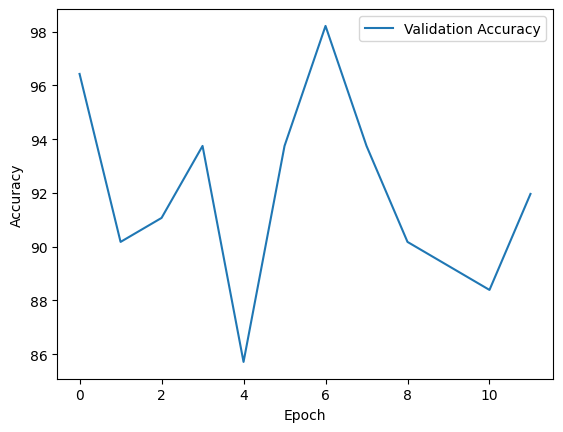

In [30]:
# plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.ylim([80, 100])
plt.show()